# Setting up the stage

In [14]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import sys
import time
import seaborn as sns
import os
import math
import pickle as pkl

#%%
# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_auc_score,
    classification_report,
    roc_curve, 
    auc
)
import torch
import torch.nn as nn
import torch.optim as optim

# # Anomaly detection models
# import pyod
# from pyod.models.ocsvm import OCSVM
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor


In [2]:
# Data loading
df_head = pd.read_csv('../data/creditcard_2023_head.csv')

# Loading first setup
with open('../data/setup_1.pkl', 'rb') as f:
    setup1 = pkl.load(f)

X_train, _, X_test, y_test = setup1['X_train'], setup1['y_train'], setup1['X_test'], setup1['y_test']

In [3]:
# Convert X_train to DataFrame
# Assuming the first column is 'id' and the last column is 'amount'
columns = ['Feature_' + str(i) for i in range(1, X_train.shape[1]-1)] + ['Amount']
X_train_df = pd.DataFrame(X_train[:, 1:], columns=columns)  # Excluding 'id'

In [ ]:
# Histograms for feature distributions (excluding 'id')
X_train_df.hist(bins=50, figsize=(20,15))
plt.show()

# Box plots for the transaction amount
sns.boxplot(x=X_train_df['Amount'])
plt.show()

# Box plots for other features
for col in X_train_df.drop('Amount', axis=1).columns:
    sns.boxplot(x=X_train_df[col])
    plt.show()

# Anomaly Scoring

## Model training

Prototyping with only 10000 instances.

In [16]:
X_train_mini = X_train[:10000]

In [17]:
# Timing and Training the One-Class SVM model
start_time = time.time()
oc_svm = OneClassSVM().fit(X_train_mini)
oc_svm_duration = time.time() - start_time
print(f"One-Class SVM training time: {oc_svm_duration:.2f} seconds")

One-Class SVM training time: 5.29 seconds


## Evaluation

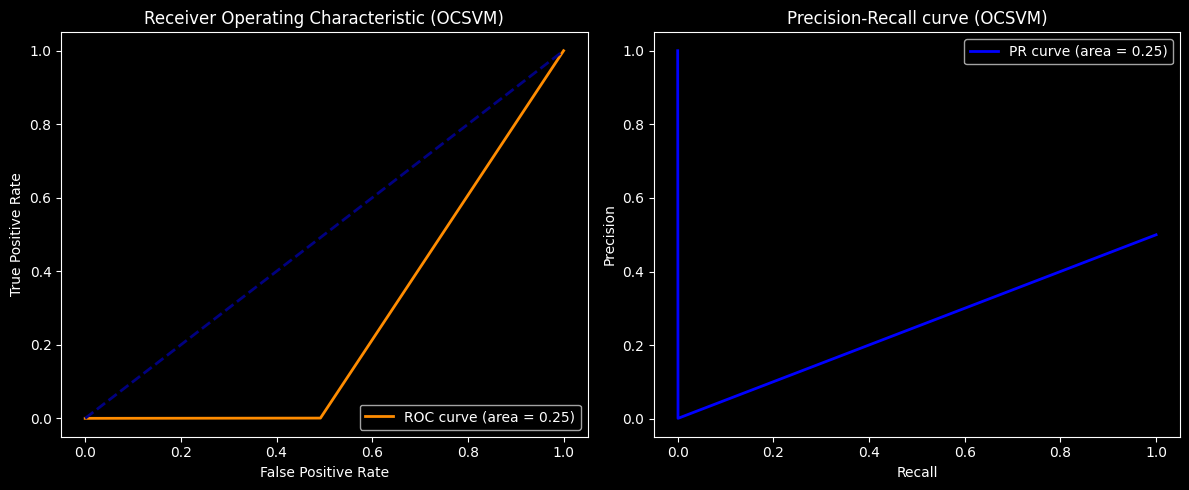

              precision    recall  f1-score   support

           0       0.34      0.51      0.41     28432
           1       0.00      0.00      0.00     28432

    accuracy                           0.25     56864
   macro avg       0.17      0.25      0.20     56864
weighted avg       0.17      0.25      0.20     56864



In [18]:
# Predict on the test set
y_pred_test = oc_svm.predict(X_test)
# Convert predictions to match y_test labels (0 for anomalies, 1 for normal)
y_pred_test = (y_pred_test == 1).astype(int)

# Calculate ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall Curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)
pr_auc = auc(recall, precision)

# Generate a classification report
class_report = classification_report(y_test, y_pred_test)

# Plotting the ROC and Precision-Recall Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (OCSVM)')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (OCSVM)')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

print(class_report)